In [17]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
df = pd.read_csv("C:/Users/asus iultra 9 2024/Downloads/nyc data/csv for arima 3 - Copie.csv", sep=";")


In [28]:
# Drop useless column if exists
if "Unnamed: 7" in df.columns:
    df = df.drop(columns=["Unnamed: 7"])

# Date → datetime
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

# Columns that MUST be numeric
num_cols = ["Est Visitors (millions)", "Trips", "Fare", "Tips", "EventIntensity"]

for col in num_cols:
    # Replace comma decimals "0,5" → "0.5", then convert to float
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Year column
df["Year"] = df["Date"].dt.year

df.dtypes


Date                       datetime64[ns]
Weekday                            object
Est Visitors (millions)           float64
Trips                               int64
Tips                              float64
Fare                              float64
EventIntensity                    float64
Year                                int32
dtype: object

In [29]:
# Set NA only for 2026 rows so they are clearly 'to forecast'
mask_2026 = df["Year"] == 2026
df.loc[mask_2026, ["Trips", "Fare", "Tips"]] = pd.NA

# History = 2024 + 2025
hist = df[df["Year"] <= 2025].copy()
future = df[df["Year"] == 2026].copy()

# Use Date as index
hist = hist.set_index("Date")
future = future.set_index("Date")

exog_cols = ["Est Visitors (millions)", "EventIntensity"]
X_hist = hist[exog_cols]
X_future = future[exog_cols]

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_and_forecast(target_col, order=(1,1,1), seasonal_order=(1,0,1,7)):
    # 1) Target as numeric
    y = pd.to_numeric(hist[target_col], errors="coerce")

    # 2) Keep only rows where y is not NA, and align X
    mask = y.notna()
    y = y[mask]
    X = X_hist.loc[mask].astype(float)

    # 3) Fit SARIMAX
    model = SARIMAX(
        y,
        exog=X,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit()
    print(f"{target_col} model fitted. AIC = {res.aic:.2f}")

    # 4) Forecast for 2026 using numeric exog
    Xf = X_future.astype(float)
    fc = res.get_forecast(steps=len(Xf), exog=Xf)

    mean = fc.predicted_mean
    ci = fc.conf_int()

    return mean, ci, res


In [31]:
future_fc = future.copy()

for target in ["Trips", "Fare", "Tips"]:
    mean, ci, res = fit_and_forecast(target)

    future_fc[f"{target}Forecast"] = mean.values
    future_fc[f"{target}Lower"]    = ci.iloc[:, 0].values
    future_fc[f"{target}Upper"]    = ci.iloc[:, 1].values

future_fc.head()
future_fc.tail()


C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trips model fitted. AIC = 1097.37


C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_mo

Fare model fitted. AIC = 1394.28
Tips model fitted. AIC = 1199.62


C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus iultra 9 2024\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_mo

,Weekday,Est Visitors (millions),Trips,Tips,Fare,EventIntensity,Year,TripsForecast,TripsLower,TripsUpper,FareForecast,FareLower,FareUpper,TipsForecast,TipsLower,TipsUpper
Date,,,,,,,,,,,,,,,,
2026-07-10,Fri,0.2589,NaN,NaN,NaN,0.5,2026,110995.102021,-9194.677845,231184.881887,2.324434e+06,-206864.203531,4.855732e+06,283828.610948,-133396.437701,701053.659596
2026-07-11,Sat,0.3352,NaN,NaN,NaN,0.0,2026,103096.407512,-19297.004056,225489.819081,2.210509e+06,-367480.641453,4.788499e+06,234218.561899,-190302.505197,658739.628995
2026-07-12,Sun,0.3052,NaN,NaN,NaN,0.0,2026,104844.106328,-19713.487609,229401.700264,2.229675e+06,-394175.891664,4.853526e+06,253294.731845,-178399.062810,684988.526499
2026-07-13,Mon,0.3652,NaN,NaN,NaN,0.5,2026,104816.430527,-21868.059748,231500.920801,2.256526e+06,-412397.835289,4.925450e+06,216235.376733,-222513.900736,654984.654202
2026-07-14,Tue,0.5389,NaN,NaN,NaN,1.0,2026,98174.515053,-30601.529568,226950.559675,2.210740e+06,-502507.517919,4.923988e+06,106877.334586,-338815.748903,552570.418074


In [32]:
future_out = future_fc.reset_index()[[
    "Date",
    "Weekday",
    "Est Visitors (millions)",
    "EventIntensity",
    "TripsForecast","TripsLower","TripsUpper",
    "FareForecast","FareLower","FareUpper",
    "TipsForecast","TipsLower","TipsUpper"
]]

future_out.to_csv("nyc_taxi_forecast_2026.csv", index=False)

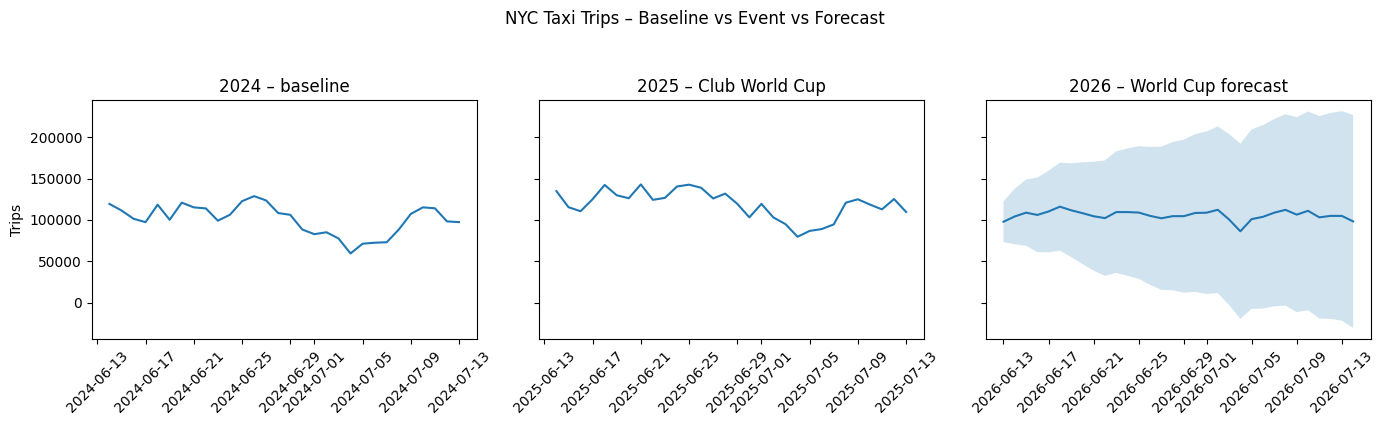

In [33]:
import matplotlib.pyplot as plt

# assuming:
# - hist has Date index and columns Trips, Fare, Tips, Year
# - future_fc has Date index, Year=2026, and TripsForecast

hist_2024 = hist[hist["Year"] == 2024]
hist_2025 = hist[hist["Year"] == 2025]
future_26 = future_fc.copy()          # Year = 2026

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# ----- 2024 -----
axes[0].plot(hist_2024.index, hist_2024["Trips"])
axes[0].set_title("2024 – baseline")
axes[0].set_ylabel("Trips")

# ----- 2025 -----
axes[1].plot(hist_2025.index, hist_2025["Trips"])
axes[1].set_title("2025 – Club World Cup")

# ----- 2026 forecast -----
axes[2].plot(future_26.index, future_26["TripsForecast"])
axes[2].fill_between(
    future_26.index,
    future_26["TripsLower"],
    future_26["TripsUpper"],
    alpha=0.2
)
axes[2].set_title("2026 – World Cup forecast")

for ax in axes:
    ax.tick_params(axis="x", rotation=45)

fig.suptitle("NYC Taxi Trips – Baseline vs Event vs Forecast", y=1.05)
plt.tight_layout()
plt.show()


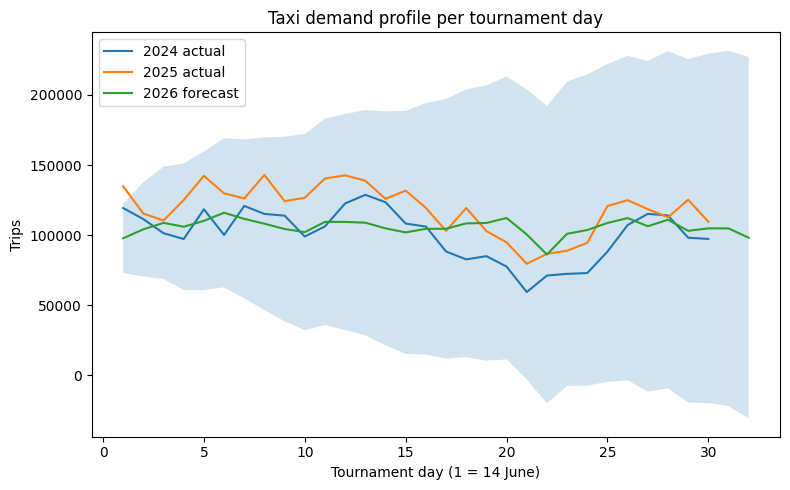

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Rebuild a "DayOfTournament" index
hist_period = hist.copy()
future_period = future_fc.copy()

hist_period["DayOfTournament"] = (
    hist_period.groupby("Year").cumcount() + 1
)
future_period["DayOfTournament"] = (
    future_period.groupby("Year").cumcount() + 1
)

h24 = hist_period[hist_period["Year"] == 2024]
h25 = hist_period[hist_period["Year"] == 2025]
f26 = future_period[future_period["Year"] == 2026]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(h24["DayOfTournament"], h24["Trips"], label="2024 actual")
ax.plot(h25["DayOfTournament"], h25["Trips"], label="2025 actual")
ax.plot(f26["DayOfTournament"], f26["TripsForecast"], label="2026 forecast")

ax.fill_between(
    f26["DayOfTournament"],
    f26["TripsLower"],
    f26["TripsUpper"],
    alpha=0.2
)

ax.set_xlabel("Tournament day (1 = 14 June)")
ax.set_ylabel("Trips")
ax.set_title("Taxi demand profile per tournament day")
ax.legend()
plt.tight_layout()
plt.show()


In [38]:
future_out.to_csv(
    r"C:\Users\asus iultra 9 2024\Desktop\nyc_taxi_forecast_2026_v2.csv",
    index=False
)
